<a href="https://colab.research.google.com/github/arjencupido/METSIM/blob/main/20210901_Machine_learning_template_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Google Colab script for machine learning

First, import data:

In [11]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  

Saving atlas1006_taxa.txt to atlas1006_taxa (1).txt
Saving atlas1006_sample.txt to atlas1006_sample (1).txt
Saving atlas1006_OTU.txt to atlas1006_OTU (1).txt
User uploaded file "atlas1006_taxa.txt" with length 11580 bytes


NameError: ignored

## Load the data, import dummy variables. 

In [23]:
# Load data, create dummy variables. 

import pandas as pd
import numpy as np
otu = pd.read_csv('atlas1006_OTU.txt',  sep = ' ')
sample = pd.read_csv('atlas1006_sample.txt', sep = ' ')

# Set seed for reproducibility
np.random.seed(55)

sample['hba1c'] = np.random.randint(4,8, sample.shape[0])
print(sample['hba1c'])
sample['FG'] = np.random.randint(0,20, sample.shape[0])

Sample-1       5
Sample-2       6
Sample-3       7
Sample-4       4
Sample-5       5
              ..
Sample-1168    7
Sample-1169    6
Sample-1170    5
Sample-1171    5
Sample-1172    7
Name: hba1c, Length: 1151, dtype: int64


## some exploratory analyses

(array([296.,   0.,   0., 288.,   0.,   0., 290.,   0.,   0., 277.]),
 array([4. , 4.3, 4.6, 4.9, 5.2, 5.5, 5.8, 6.1, 6.4, 6.7, 7. ]),
 <a list of 10 Patch objects>)

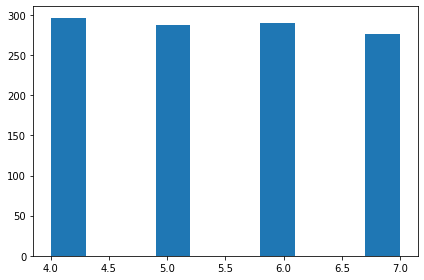

In [29]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, sharey=True, tight_layout=True)

axs.hist(sample['hba1c'])




In [32]:
sample['bmi_group'].value_counts()

lean           484
obese          222
overweight     197
severeobese     99
morbidobese     22
underweight     21
Name: bmi_group, dtype: int64

## Data cleaning

In [65]:
sample[:10]

bmi_cat = sample[['bmi_group']]

print(bmi_cat.value_counts())

print('is NA: ',bmi_cat.isnull().sum())

print('correct NA for lean')
bmi_cat.fillna("lean", inplace=True, )

print('is NA: ', bmi_cat.isnull().sum())

print(bmi_cat.value_counts())

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

bmi_cat_encoded = ordinal_encoder.fit_transform(bmi_cat)

print(bmi_cat_encoded[:25])

print('The categories are: ',ordinal_encoder.categories_)

otu_transposed = otu.transpose()

bmi_group  
lean           484
obese          222
overweight     197
severeobese     99
morbidobese     22
underweight     21
dtype: int64
is NA:  bmi_group    106
dtype: int64
correct NA for lean
is NA:  bmi_group    0
dtype: int64
bmi_group  
lean           590
obese          222
overweight     197
severeobese     99
morbidobese     22
underweight     21
dtype: int64
[[4.]
 [2.]
 [0.]
 [5.]
 [0.]
 [0.]
 [5.]
 [0.]
 [0.]
 [0.]
 [5.]
 [0.]
 [0.]
 [0.]
 [2.]
 [4.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [3.]
 [0.]
 [0.]]
The categories are:  [array(['lean', 'morbidobese', 'obese', 'overweight', 'severeobese',
       'underweight'], dtype=object)]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


## Regression

In [85]:
# Regression model

from sklearn.linear_model import LinearRegression

print('Lets predict HbA1c with the OTU data, using linear regression:')

lin_reg = LinearRegression()
lin_reg.fit(otu_transposed, sample['hba1c'])


print("Predictions:", lin_reg.predict(otu_transposed[:10]))

print("Labels:", list(sample['hba1c'][:10]))



from sklearn.metrics import mean_squared_error
hb1ac_predictions_lin = lin_reg.predict(otu_transposed)
lin_mse = mean_squared_error(sample['hba1c'], hb1ac_predictions_lin)
lin_rmse = np.sqrt(lin_mse)
print('mean squared error: ', lin_rmse)

Lets predict HbA1c with the OTU data:
Predictions: [5.16907495 5.76090344 5.66280636 5.34180843 5.1879824  6.10815069
 5.69942005 5.22365364 7.01308994 5.48310907]
Labels: [5, 6, 7, 4, 5, 5, 5, 5, 7, 5]
mean squared error:  1.0485254767914365


## Decision tree regression

In [84]:
# Let's try a decision tree regressor
print('Lets predict HbA1c with the OTU data, using decision tree regressor:')
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()

tree_reg.fit(otu_transposed, sample['hba1c'])

print("Predictions:", tree_reg.predict(otu_transposed[:10]))

print("Labels:", list(sample['hba1c'][:10]))




# Now that the model is trained, let’s evaluate it on the training set:
hba1c_predictions_tree = tree_reg.predict(otu_transposed)
tree_mse = mean_squared_error(sample['hba1c'], hba1c_predictions_tree)
tree_rmse = np.sqrt(tree_mse)
print('Mean squared error: ',tree_rmse)



Predictions: [5. 6. 7. 4. 5. 5. 5. 5. 7. 5.]
Labels: [5, 6, 7, 4, 5, 5, 5, 5, 7, 5]
Mean squared error:  0.09775943451840757


## train test split and comparison 

In [86]:
# Train-test-split

from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, otu_transposed, sample['hba1c'],
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [99]:
print("regression tree")
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

lin_scores = cross_val_score(lin_reg, otu_transposed, sample['hba1c'],
scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
print("linear regression")
display_scores(lin_rmse_scores)

regression tree
Scores: [1.43313618 1.48030549 1.58594369 1.6365393  1.54145612 1.59891267
 1.49054994 1.57700873 1.53509665 1.66093216]
Mean: 1.5539880935322887
Standard deviation: 0.06811292811922018
linear regression
Scores: [1.23571299 1.04707947 1.58938253 1.41107391 1.21807625 1.15111304
 1.64018448 1.53596589 1.26754698 1.2264652 ]
Mean: 1.332260074544109
Standard deviation: 0.18987335934145355


In [106]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()

forest_reg.fit(otu_transposed, sample['hba1c'])

hba1c_predictions_forest = tree_reg.predict(otu_transposed)
forest_mse = mean_squared_error(sample['hba1c'], hba1c_predictions_forest)
forest_rmse = np.sqrt(tree_mse)  

forest_scores = cross_val_score(forest_reg, otu_transposed, sample['hba1c'],
scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [1.08250735 1.07085201 1.1635908  1.09921973 1.180988   1.12209728
 1.10762225 1.12813459 1.16271907 1.15792343]
Mean: 1.1275654522842093
Standard deviation: 0.03575928108742667
